In [1]:
import matplotlib.pyplot as plt
import math

In [20]:
# Data Load
train = np.load("FireEvac_train_set.npy")
test = np.load("FireEvac_test_set.npy")

#Finding right scale to normalize data
max_train = np.amax(train,axis = 0)
min_train = np.amin(train,axis = 0)
max_range_x = max_train[0]-min_train[0]
max_range_y = max_train[1]-min_train[1]
scale = max(max_range_x,max_range_y)
# print(max_train)
# print(min_train)
# print(train.shape)


train = np.expand_dims(train, -1).astype("float32") / scale
test = np.expand_dims(test, -1).astype("float32") / scale

# Plotting Data - FireEvac train/test set

Text(0.5,1,'Scatter plot for training set')

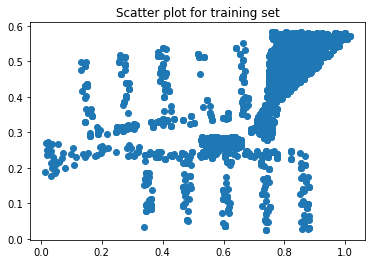

In [21]:
plt.plot(train[:,0], train[:,1], 'o');
plt.title('Scatter plot for training set')

Text(0.5,1,'Scatter plot for test set')

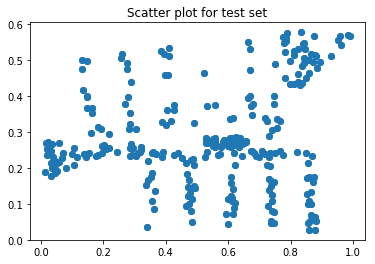

In [22]:
plt.plot(test[:,0], test[:,1], 'o');
plt.title('Scatter plot for test set')

In [23]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder,**kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def train_step(self, data):
        with tf.GradientTape() as tape:
            
            z_mean, z_std, z = self.encoder(data)
            # reconstruction_loss is changed due to different shape of MI Building Data
            # Mean axis is set to 0 instead of (1,2) in Task3
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, self.decoder(z)), axis=(0)))
            latent_loss = -0.5 * (1 + z_std - tf.square(z_mean) - tf.exp(z_std))
            latent_loss = tf.reduce_mean(tf.reduce_sum(latent_loss, axis=1))
            total_loss = reconstruction_loss + latent_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "total_loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "latent_loss": latent_loss,
        }

# Encoder

In [24]:
latent_space = 2
MI_input = keras.Input(shape=(2,1))# MI building data consists of 2x1 positional data
flattened_input = layers.Reshape((2,), name="Reshape")(MI_input)  
hidden_1_e = layers.Dense(256, activation="relu")(flattened_input)
hidden_2_e = layers.Dense(256, activation="relu")(hidden_1_e)
encoder_mean = layers.Dense(latent_space, name = 'encoder_mean')(hidden_2_e)
encoder_std = layers.Dense(latent_space, name = 'encoder_std')(hidden_2_e)

# Sampling z from x s.t. z = mu + L*epsilon
batch = tf.shape(encoder_mean)[0]
dimension = tf.shape(encoder_mean)[1]
epsilon = tf.keras.backend.random_normal(shape=(batch, dimension))
sample_z = encoder_mean + tf.sqrt(tf.exp(encoder_std)) * epsilon
encoder = keras.Model(MI_input, [encoder_mean, encoder_std, sample_z], name="encoder")

# Decoder

In [25]:
latent_input = keras.Input(shape=(latent_space,)) # z's input
hidden_1_d = layers.Dense(256, activation="relu")(latent_input)
hidden_2_d = layers.Dense(256, activation="relu")(hidden_1_d)
decoder_output = layers.Dense(2, activation="sigmoid", name="decoder_output")(hidden_2_d)
decoder_output = layers.Reshape((2, 1), name="Reshape")(decoder_output) 
decoder = keras.Model(latent_input, decoder_output, name="decoder")

# Training

In [73]:
latent_space = 2
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001))
vae.fit(train, epochs=100, batch_size=128) 

Epoch 1/100
24/24 [==============================] - 1s 5ms/step - total_loss: 72.6394 - reconstruction_loss: 71.0176 - latent_loss: 1.6218
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - total_loss: 72.5563 - reconstruction_loss: 70.9513 - latent_loss: 1.6050
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - total_loss: 72.6345 - reconstruction_loss: 71.0238 - latent_loss: 1.6108
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - total_loss: 72.6361 - reconstruction_loss: 71.0126 - latent_loss: 1.6235
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - total_loss: 72.5664 - reconstruction_loss: 70.9409 - latent_loss: 1.6256
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - total_loss: 72.6453 - reconstruction_loss: 71.0256 - latent_loss: 1.6197
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - total_loss: 72.5469 - reconstruction_loss: 70.9468 - latent_loss: 1.6001
Epoch 8/100
24/24 [=

24/24 [==============================] - 0s 6ms/step - total_loss: 72.5346 - reconstruction_loss: 70.9150 - latent_loss: 1.6196
Epoch 59/100
24/24 [==============================] - 0s 6ms/step - total_loss: 72.6114 - reconstruction_loss: 70.9696 - latent_loss: 1.6418
Epoch 60/100
24/24 [==============================] - 0s 5ms/step - total_loss: 72.5919 - reconstruction_loss: 70.9807 - latent_loss: 1.6111
Epoch 61/100
24/24 [==============================] - 0s 5ms/step - total_loss: 72.6377 - reconstruction_loss: 70.9721 - latent_loss: 1.6655
Epoch 62/100
24/24 [==============================] - 0s 5ms/step - total_loss: 72.5568 - reconstruction_loss: 70.9826 - latent_loss: 1.5742
Epoch 63/100
24/24 [==============================] - 0s 5ms/step - total_loss: 72.5726 - reconstruction_loss: 70.9804 - latent_loss: 1.5923
Epoch 64/100
24/24 [==============================] - 0s 5ms/step - total_loss: 72.5909 - reconstruction_loss: 70.9631 - latent_loss: 1.6278
Epoch 65/100
24/24 [======

# Reconstructed Test Set

(600, 2, 1)


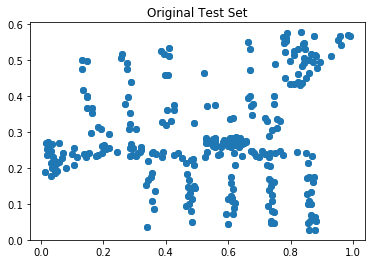

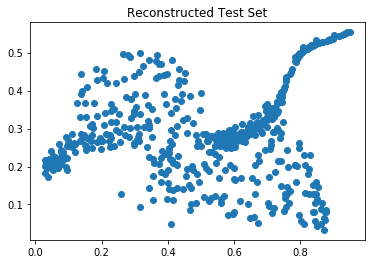

In [74]:
_,_,encoder_output = encoder.predict(test)
reconstructed_test = decoder.predict(encoder_output)
#print(reconstructed_test.shape)
plt.title("Original Test Set")
plt.plot(test[:,0], test[:,1], 'o');
plt.show()
plt.title("Reconstructed Test Set")
plt.plot(reconstructed_test[:,0], reconstructed_test[:,1], 'o');
plt.show()

# 1000 Generated Samples

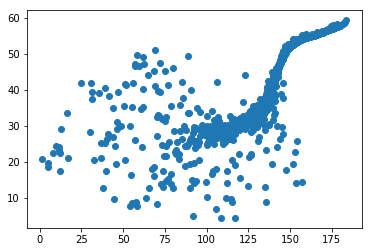

In [88]:
encoder_output = np.random.normal(size=(1000,2)) #Random 1000 z samples
reconstructed = decoder.predict(encoder_output)
reconstructed = reconstructed * np.array(([max_range_x],[max_range_y]))
#print(reconstructed[0])

plt.plot(reconstructed[:,0], reconstructed[:,1], 'o');
plt.show()

# Finding Critical Number of People in the area

In [76]:
# 800 people case
number_of_people = 500
encoder_output = np.random.normal(size=(number_of_people,2)) # 500 z samples
reconstructed = decoder.predict(encoder_output)
reconstructed *= scale
#(130/70 & 150/50)
count = 0
for i in range(len(reconstructed)):
    if reconstructed[i][0]<=150 and reconstructed[i][0]>=130 and reconstructed[i][1]<=70 and reconstructed[i][1]>=50:
        count+=1
print("Number of People in the sensitive area while "+str(number_of_people)+" people in the MI Building : "+str(count))

Number of People in the sensitive area while 500 people in the MI Building : 53


In [87]:
# 800 people case
number_of_people = 900
encoder_output = np.random.normal(size=(number_of_people,2)) # 900 z samples
reconstructed = decoder.predict(encoder_output)
reconstructed *= scale
#(130/70 & 150/50)
count = 0
for i in range(len(reconstructed)):
    if reconstructed[i][0]<=150 and reconstructed[i][0]>=130 and reconstructed[i][1]<=70 and reconstructed[i][1]>=50:
        count+=1
print("Number of People in the sensitive area while "+str(number_of_people)+" people in the MI Building : "+str(count))

Number of People in the sensitive area while 900 people in the MI Building : 71


In [84]:
# 950 people case
number_of_people = 950
encoder_output = np.random.normal(size=(number_of_people,2)) # 950 z samples
reconstructed = decoder.predict(encoder_output)
reconstructed *= scale
#(130/70 & 150/50)
count = 0
for i in range(len(reconstructed)):
    if reconstructed[i][0]<=150 and reconstructed[i][0]>=130 and reconstructed[i][1]<=70 and reconstructed[i][1]>=50:
        count+=1
print("Number of People in the sensitive area while "+str(number_of_people)+" people in the MI Building : "+str(count))

Number of People in the sensitive area while 950 people in the MI Building : 102
